In [10]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

random forest models modified. changed criterion to absolute error

In [11]:
def add_t_minus(df, n):
    if n == 0:
        return df
    df_res = df.copy()
    for i in range(1,n+1):
        df_shifted = df.shift(i)
        for cname in df_shifted.columns:
            df_shifted.rename(columns = {cname:cname+'_'+str(i)}, inplace = True)
        df_res = df_res.join(df_shifted)
    df_res = df_res.interpolate(method='spline', limit_direction='backward', order=1)
    return df_res

def sj_preprocess_data(features, labels=None, tminus=0):
    pruned = ['weekofyear', 'ndvi_nw', 'ndvi_se', 'reanalysis_dew_point_temp_k',
       'reanalysis_specific_humidity_g_per_kg']
    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    #features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="spline", order=1)
    
    if labels is not None:
        #nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        nfeatures = add_t_minus(features[pruned], tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features[pruned], tminus)


def iq_preprocess_data(features, labels=None, tminus=0):
    pruned = ['weekofyear', 'ndvi_nw', 'ndvi_sw', 'reanalysis_air_temp_k',
       'reanalysis_dew_point_temp_k', 'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c',
       'station_min_temp_c', 'station_precip_mm']

    if labels is not None:
        features = features.join(labels)

    #features['month'] = features['week_start_date'].dt.month
    
    
    features.reset_index(inplace=True)
    features.set_index('week_start_date',inplace=True)
    features = features.drop('year', axis=1)

    #features = features.drop('weekofyear', axis=1)

    features = features.interpolate(method="spline", order=1)
    
    if labels is not None:
        #nfeatures = add_t_minus(features.drop('total_cases', axis=1), tminus)
        nfeatures = add_t_minus(features[pruned], tminus)
        return nfeatures, features['total_cases']
    else:
        return add_t_minus(features[pruned], tminus)



def get_data(features_path, labels_path=None, sj_tminus=0, iq_tminus=0):
    if labels_path is not None:
        labels = pd.read_csv(labels_path,
                           index_col=[0,1,2])

    features = pd.read_csv(features_path,
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

    # Separate data for San Juan
    sj_features = features.loc['sj']
    if labels_path is not None:
        sj_labels = labels.loc['sj']

    # Separate data for Iquitos
    iq_features = features.loc['iq']
    if labels_path is not None:
        iq_labels = labels.loc['iq']

    if labels_path is not None:
        sj_f, sj_l = sj_preprocess_data(sj_features, sj_labels, sj_tminus)
        iq_f, iq_l = iq_preprocess_data(iq_features, iq_labels, iq_tminus)
        return sj_f, sj_l, iq_f, iq_l

    return sj_preprocess_data(sj_features, None, sj_tminus), iq_preprocess_data(iq_features, None, iq_tminus)


In [12]:
sj_tminus = 2
iq_tminus = 2
sj_X_train, sj_y_train, iq_X_train, iq_y_train = get_data('dengue_features_train.csv',
                                                        'dengue_labels_train.csv',
                                                        sj_tminus=sj_tminus,
                                                        iq_tminus=iq_tminus,
                                                        )

# load the provided data
train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2],
                             parse_dates=['week_start_date'])

train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

# Separate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

sj_X_train, sj_y_train = preprocess_data(sj_train_features,sj_train_labels)

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

iq_X_train, iq_y_train = preprocess_data(iq_train_features,iq_train_labels)

In [13]:
#split data in train and test
sj_X_train, sj_X_test, sj_y_train, sj_y_test = train_test_split(
    sj_X_train, sj_y_train, test_size=0.3, shuffle=False)


iq_X_train, iq_X_test, iq_y_train, iq_y_test = train_test_split(
iq_X_train, iq_y_train, test_size=0.3, shuffle=False)

#remove everythin before 2002, it doesnt seem to have any value
iq_X_train = iq_X_train.loc['2002-01-01':]
iq_y_train = iq_y_train.loc['2002-01-01':]


In [14]:
sj_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekofyear,655.0,26.810687,14.858483,1.000000,14.000000,27.000000,40.000000,53.000000
ndvi_nw,655.0,0.096682,0.078717,-0.130950,0.050250,0.090200,0.134000,0.437100
ndvi_se,655.0,0.181044,0.054837,0.036000,0.146207,0.178579,0.212529,0.393129
reanalysis_dew_point_temp_k,655.0,295.067408,1.566198,289.642857,293.840714,295.447143,296.355714,297.467143
reanalysis_specific_humidity_g_per_kg,655.0,16.508540,1.547369,11.715714,15.237143,16.837143,17.805714,19.044286
weekofyear_1,655.0,26.763152,14.840383,1.000000,14.000000,27.000000,39.500000,53.000000
ndvi_nw_1,655.0,0.096965,0.078568,-0.130950,0.050750,0.090267,0.134550,0.437100
ndvi_se_1,655.0,0.180894,0.054708,0.036000,0.146207,0.178579,0.212386,0.393129
reanalysis_dew_point_temp_k_1,655.0,295.065684,1.565689,289.642857,293.840714,295.438571,296.355714,297.467143
reanalysis_specific_humidity_g_per_kg_1,655.0,16.507052,1.546873,11.715714,15.237143,16.831429,17.805714,19.044286


In [15]:
iq_X_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
weekofyear,286.0,25.321678,14.994315,1.000000,12.250000,24.000000,38.000000,53.000000
ndvi_nw,286.0,0.232114,0.075149,0.072986,0.174711,0.224271,0.284818,0.428771
ndvi_sw,286.0,0.260263,0.081016,0.064743,0.205636,0.258582,0.315911,0.493443
reanalysis_air_temp_k,286.0,297.842963,1.097544,294.635714,297.162500,297.807857,298.459286,301.175714
reanalysis_dew_point_temp_k,286.0,295.519940,1.404300,290.088571,294.573571,295.975714,296.575357,297.852857
reanalysis_precip_amt_kg_per_m2,286.0,54.558408,49.941984,0.100000,23.397500,42.925000,66.245000,362.030000
reanalysis_specific_humidity_g_per_kg,286.0,17.121352,1.426131,12.111429,16.079286,17.544286,18.212500,19.731429
reanalysis_tdtr_k,286.0,9.164627,2.410604,4.185714,7.371429,8.992857,10.942857,16.028571
station_avg_temp_c,286.0,27.592878,0.917537,21.400000,27.206250,27.650000,28.225000,30.800000
station_diur_temp_rng_c,286.0,10.279301,1.511783,5.200000,9.283978,10.166667,11.161828,15.800000


In [16]:
# compute the correlations
sj_correlations = sj_X_train.corr()
iq_correlations = iq_X_train.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

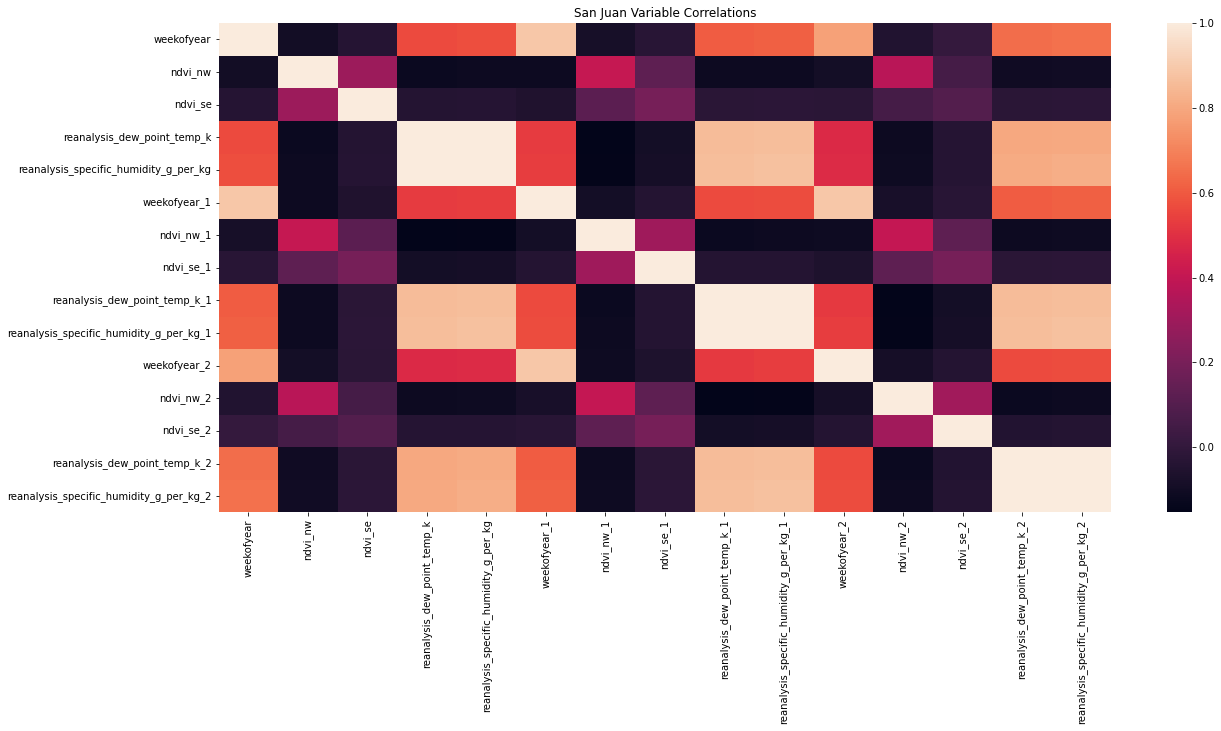

In [17]:
plt.rcParams["figure.figsize"] = (20,9)

# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations)
plt.title('San Juan Variable Correlations')

In [18]:
'''sj_rf = RandomForestRegressor(  n_estimators = 100, 
                                min_samples_leaf=25, 
                                criterion='absolute_error',
                                max_depth = 4)'''

sj_rf = RandomForestRegressor(  n_estimators = 100,
                                min_samples_leaf=5,
                                criterion='squared_error',
                                )                               
sj_rf.fit(sj_X_train, sj_y_train)
print(mean_absolute_error(sj_y_train, sj_rf.predict(sj_X_train)))
print(mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))

14.708997821720999
23.124665591999968


In [19]:
sj_rf.feature_importances_

array([0.10177806, 0.14210952, 0.0509668 , 0.02535958, 0.02204215,
       0.04881517, 0.25018834, 0.03902589, 0.01484981, 0.01321496,
       0.06103106, 0.12529285, 0.07058486, 0.01787746, 0.0168635 ])

<AxesSubplot:ylabel='cols'>

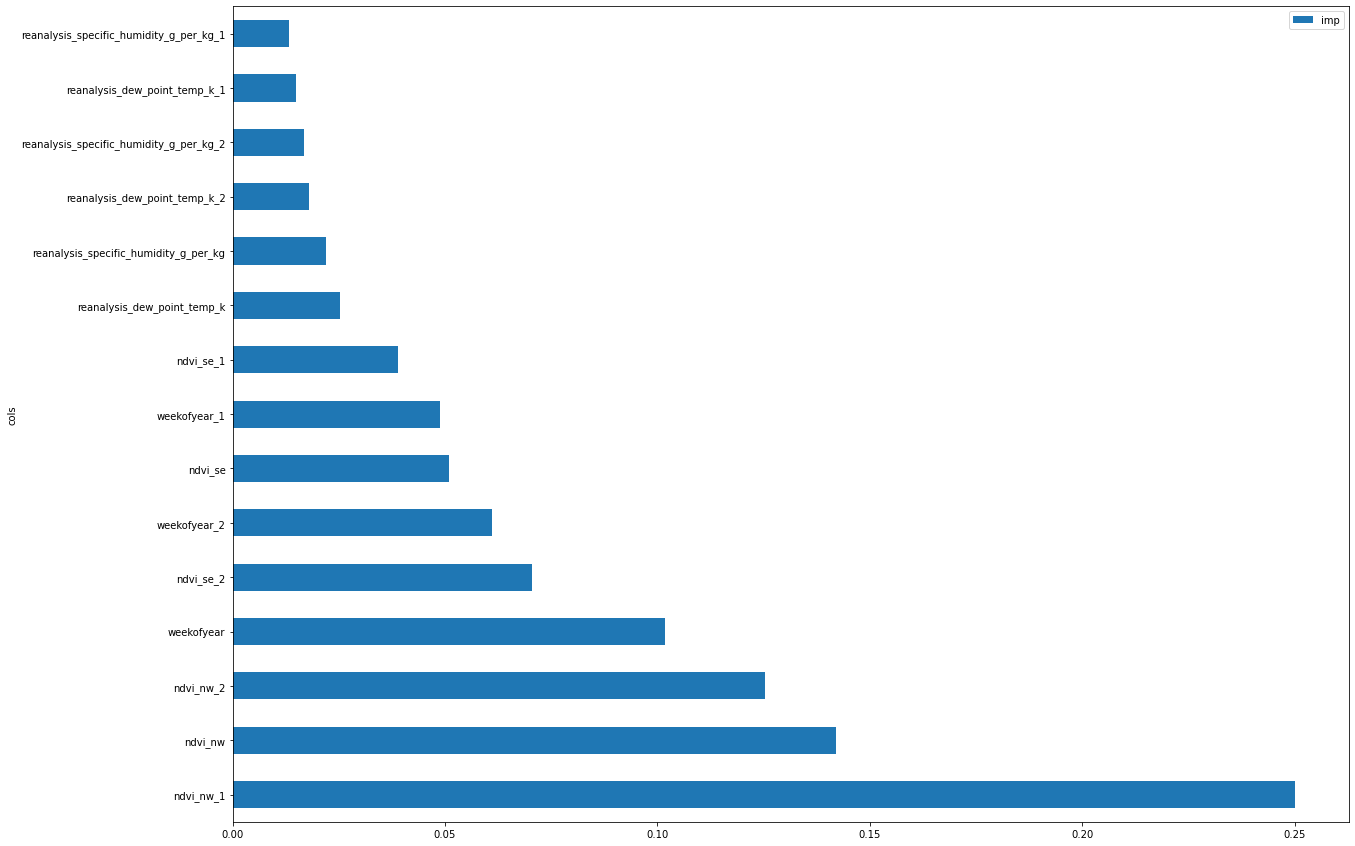

In [20]:
plt.rcParams["figure.figsize"] = (20,15)
(pd.DataFrame(dict(cols=sj_X_train.columns, imp=sj_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

In [21]:
iq_rf =  RandomForestRegressor( n_estimators = 100, 
                                min_samples_leaf=5, 
                                criterion='squared_error',
                                )

'''iq_rf = RandomForestRegressor(  n_estimators = 100,
                                min_samples_leaf=25,
                                criterion='absolute_error',)  '''
iq_rf.fit(iq_X_train, iq_y_train)
print(mean_absolute_error(iq_y_train, iq_rf.predict(iq_X_train)))
print(mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

3.7314927045444994
7.609809001128928


In [22]:
iq_rf.feature_importances_

array([0.18817662, 0.01686409, 0.01729775, 0.02998638, 0.05253431,
       0.02528901, 0.0787538 , 0.01409813, 0.01231458, 0.02400933,
       0.02295715, 0.00849757, 0.02808841, 0.05408355, 0.01517941,
       0.0154832 , 0.00791322, 0.00776508, 0.01659466, 0.01778664,
       0.02619522, 0.02165636, 0.01003919, 0.01008746, 0.048106  ,
       0.04696581, 0.02615559, 0.03625856, 0.00530595, 0.01045068,
       0.01753739, 0.03903642, 0.01455825, 0.01020884, 0.01376382,
       0.01000155])

<AxesSubplot:ylabel='cols'>

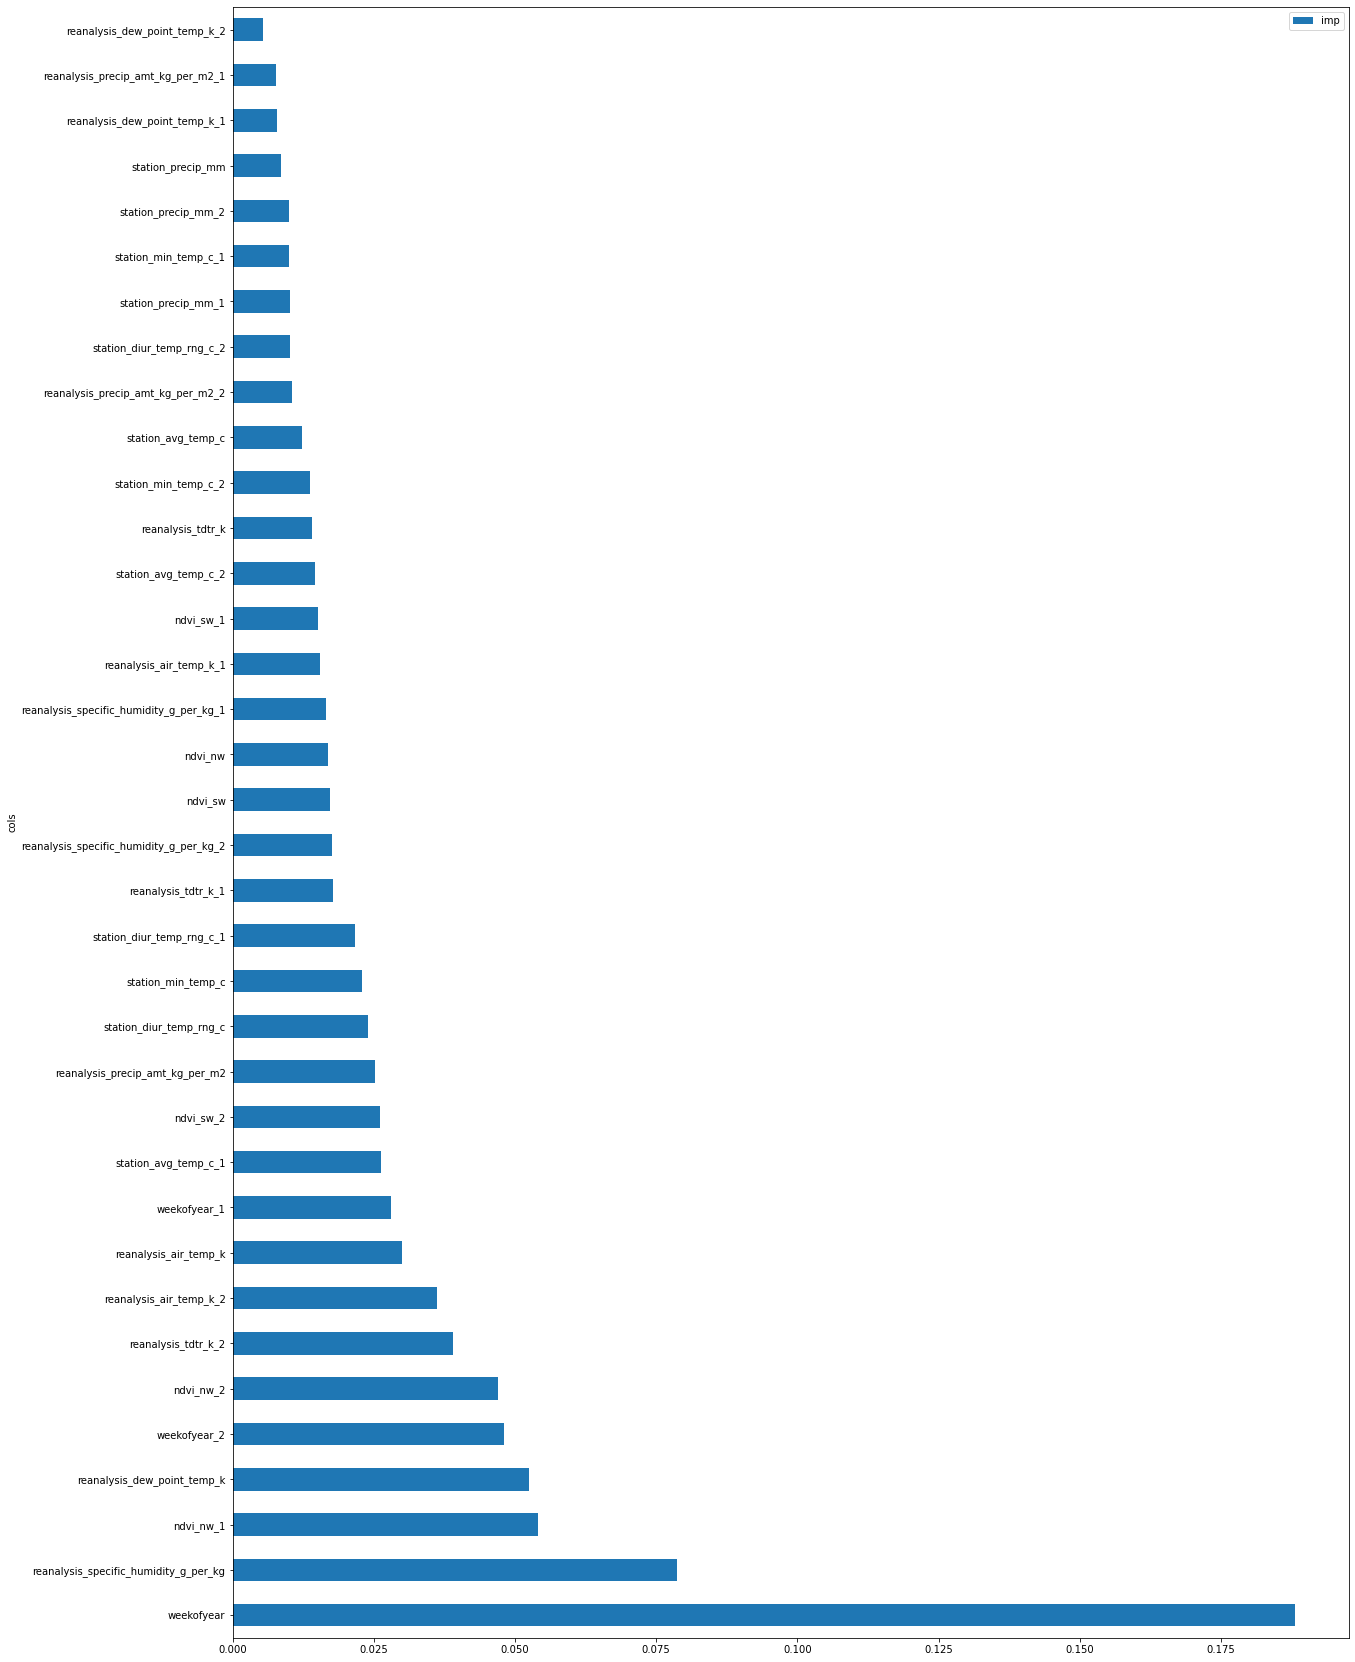

In [23]:
plt.rcParams["figure.figsize"] = (20,30)
(pd.DataFrame(dict(cols=iq_X_train.columns, imp=iq_rf.feature_importances_))
    .sort_values('imp', ascending=False)
    .plot('cols', 'imp', 'barh')
)

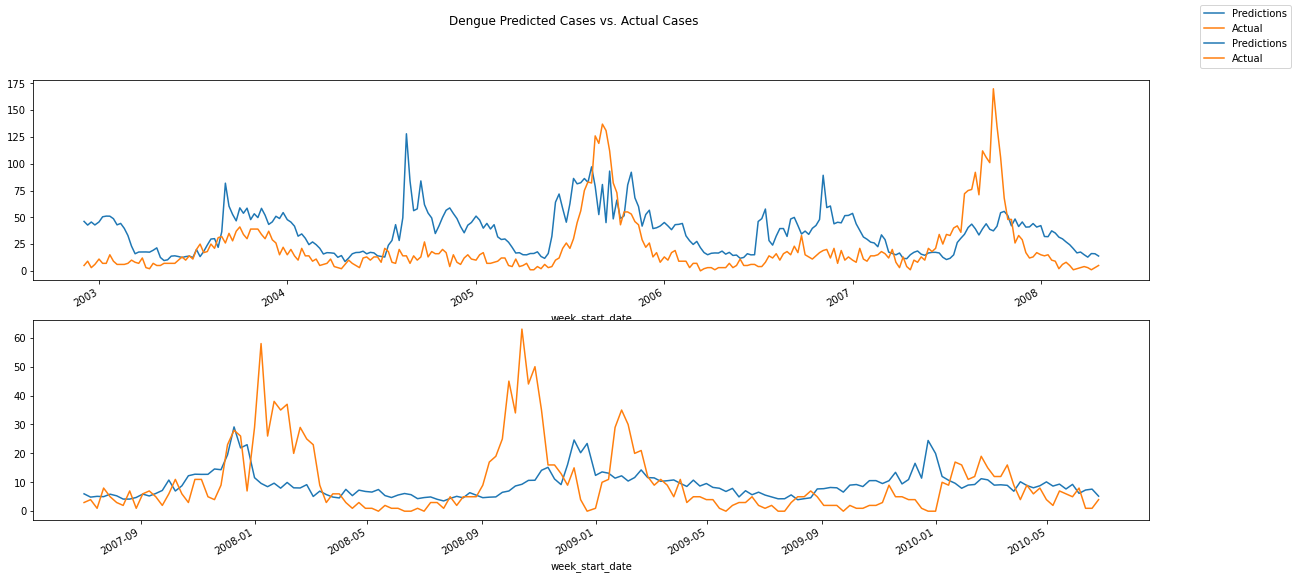

In [24]:
plt.rcParams["figure.figsize"] = (20,9)
figs, axes = plt.subplots(nrows=2, ncols=1)

# plot sj
sj_X_test['fitted'] = sj_rf.predict(sj_X_test)
sj_X_test.fitted.plot(ax=axes[0], label="Predictions")
sj_y_test.plot(ax=axes[0], label="Actual")

iq_X_test['fitted'] = iq_rf.predict(iq_X_test)
iq_X_test.fitted.plot(ax=axes[1], label="Predictions")
iq_y_test.plot(ax=axes[1], label="Actual")

figs.suptitle("Dengue Predicted Cases vs. Actual Cases")
figs.legend()

In [25]:
sj_X_test.drop('fitted',axis=1,inplace=True)
iq_X_test.drop('fitted',axis=1,inplace=True)

In [26]:
#submit data
sj_X_valid, iq_X_valid = get_data('dengue_features_test.csv',
                                    sj_tminus=sj_tminus,
                                    iq_tminus=iq_tminus,
                                    ) 

In [27]:
sj_X_valid

,weekofyear,ndvi_nw,ndvi_se,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,weekofyear_1,ndvi_nw_1,ndvi_se_1,reanalysis_dew_point_temp_k_1,reanalysis_specific_humidity_g_per_kg_1,weekofyear_2,ndvi_nw_2,ndvi_se_2,reanalysis_dew_point_temp_k_2,reanalysis_specific_humidity_g_per_kg_2
week_start_date,,,,,,,,,,,,,,,
2008-04-29,18,-0.018900,0.102729,294.527143,15.918571,17.038041,0.061456,0.183371,295.463979,16.856112,16.042434,0.061786,0.183130,295.405766,16.792062
2008-05-06,19,-0.012400,0.082043,294.395714,15.791429,18.000000,-0.018900,0.102729,294.527143,15.918571,17.036647,0.061599,0.183086,295.454349,16.844368
2008-05-13,20,0.061357,0.151083,295.308571,16.674286,19.000000,-0.012400,0.082043,294.395714,15.791429,18.000000,-0.018900,0.102729,294.527143,15.918571
2008-05-20,21,-0.019867,0.124329,294.402857,15.775714,20.000000,0.061357,0.151083,295.308571,16.674286,19.000000,-0.012400,0.082043,294.395714,15.791429
2008-05-27,22,0.039833,0.062267,294.760000,16.137143,21.000000,-0.019867,0.124329,294.402857,15.775714,20.000000,0.061357,0.151083,295.308571,16.674286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-26,13,-0.016183,0.156343,294.675714,15.985714,12.000000,0.006225,0.107514,290.987143,12.705714,11.000000,0.054875,0.244329,291.868571,13.458571
2013-04-02,14,-0.077833,0.204171,294.628571,15.881429,13.000000,-0.016183,0.156343,294.675714,15.985714,12.000000,0.006225,0.107514,290.987143,12.705714
2013-04-09,15,-0.008200,0.192700,294.948571,16.212857,14.000000,-0.077833,0.204171,294.628571,15.881429,13.000000,-0.016183,0.156343,294.675714,15.985714


In [28]:
iq_X_valid

,weekofyear,ndvi_nw,ndvi_sw,reanalysis_air_temp_k,reanalysis_dew_point_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,...,ndvi_sw_2,reanalysis_air_temp_k_2,reanalysis_dew_point_temp_k_2,reanalysis_precip_amt_kg_per_m2_2,reanalysis_specific_humidity_g_per_kg_2,reanalysis_tdtr_k_2,station_avg_temp_c_2,station_diur_temp_rng_c_2,station_min_temp_c_2,station_precip_mm_2
week_start_date,,,,,,,,,,,,,,,,,,,,,
2010-07-02,26,0.142500,0.150214,297.648571,296.118571,34.11,17.654286,9.428571,27.440,10.760,...,0.279644,298.868825,294.281925,83.321311,15.802975,10.085689,27.617109,9.453571,19.227739,15.499609
2010-07-09,27,0.272267,0.320914,298.224286,294.831429,9.10,16.320000,10.157143,27.025,9.625,...,0.279667,298.841690,294.357289,58.673062,15.887532,9.914065,27.616245,9.747160,19.300023,13.336138
2010-07-16,28,0.366457,0.255514,297.955714,296.417143,61.09,18.030000,9.557143,26.950,10.350,...,0.150214,297.648571,296.118571,34.110000,17.654286,9.428571,27.440000,10.760000,21.500000,11.200000
2010-07-23,29,0.063214,0.081957,295.715714,293.638571,19.60,15.394286,7.828571,26.900,9.700,...,0.320914,298.224286,294.831429,9.100000,16.320000,10.157143,27.025000,9.625000,21.200000,8.900000
2010-07-30,30,0.327683,0.267914,298.502857,293.892857,18.93,15.468571,11.771429,27.050,11.850,...,0.255514,297.955714,296.417143,61.090000,18.030000,9.557143,26.950000,10.350000,21.600000,22.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-05-28,22,0.380029,0.383186,297.774286,295.638571,67.60,17.185714,10.100000,27.400,9.050,...,0.277400,297.367143,296.435714,105.700000,18.038571,6.400000,28.233333,9.400000,21.400000,38.600000
2013-06-04,23,0.296343,0.350357,297.167143,295.845714,45.70,17.448571,9.657143,27.520,10.720,...,0.299429,296.880000,295.850000,124.200000,17.382857,6.700000,26.633333,8.900000,21.800000,97.300000
2013-06-11,24,0.251029,0.249771,295.831429,294.894286,45.22,16.410000,7.385714,27.200,10.075,...,0.383186,297.774286,295.638571,67.600000,17.185714,10.100000,27.400000,9.050000,21.800000,33.000000


In [29]:
b = sj_rf.predict(sj_X_valid).astype(int)
sj_predictions = sj_rf.predict(sj_X_valid).astype(int)
iq_predictions = iq_rf.predict(iq_X_valid).astype(int)

submission = pd.read_csv("submission_format.csv",
                         index_col=[0, 1, 2])

submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv("benchmark.csv")

In [30]:
sj_predictions, iq_predictions

(array([ 12,  16,  17,  14,  15,  18,  16,  15,  17,  17,  11,  14,  14,
         27,  47,  42,  56,  58,  83,  84,  64,  50,  45,  43,  48,  68,
         68,  41,  44,  43,  53,  52,  53,  44,  39,  39,  38,  32,  36,
         45,  35,  32,  25,  21,  19,  15,  13,  14,  13,  15,  15,  15,
         15,  12,  15,  14,  14,  11,  14,  15,  15,  10,  12,  17,  35,
         33,  44,  37,  20,  33,  34,  47,  42,  39,  44,  53,  64,  77,
         48,  49,  36,  43,  40,  59,  46,  51,  54,  52,  49,  53,  52,
         51,  45,  35,  36,  39,  37,  27,  18,  11,  10,  10,  11,  14,
         15,  18,  15,  13,  15,  40,  64,  81,  79,  86,  86,  84,  81,
         88,  84,  95, 109,  99,  99,  96,  88,  64,  58,  54,  83,  56,
         48,  50,  44,  66,  47,  44,  31,  41,  38,  36,  33,  41,  47,
         47,  46,  26,  30,  24,  27,  21,  13,  12,  12,  13,  13,   9,
         10,  15,  16,  17,  14,  19,  27,  52,  65,  82,  84,  84,  72,
         80,  52,  90,  66,  89,  86,  63,  64,  49

In [31]:
print('sj', mean_absolute_error(sj_y_test, sj_rf.predict(sj_X_test)))
print('iq', mean_absolute_error(iq_y_test, iq_rf.predict(iq_X_test)))

sj 23.124665591999968
iq 7.609809001128928


sj 17.274501779359433
iq 7.246260500628908

In [32]:
sj_X_test

,weekofyear,ndvi_nw,ndvi_se,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,weekofyear_1,ndvi_nw_1,ndvi_se_1,reanalysis_dew_point_temp_k_1,reanalysis_specific_humidity_g_per_kg_1,weekofyear_2,ndvi_nw_2,ndvi_se_2,reanalysis_dew_point_temp_k_2,reanalysis_specific_humidity_g_per_kg_2
week_start_date,,,,,,,,,,,,,,,
2002-12-03,49,-0.120933,0.279086,295.205714,16.578571,48.0,-0.037250,0.277329,296.092857,17.510000,47.0,-0.122500,0.222057,295.942857,17.338571
2002-12-10,50,-0.072300,0.199300,294.978571,16.327143,49.0,-0.120933,0.279086,295.205714,16.578571,48.0,-0.037250,0.277329,296.092857,17.510000
2002-12-17,51,-0.128950,0.185414,294.577143,15.918571,50.0,-0.072300,0.199300,294.978571,16.327143,49.0,-0.120933,0.279086,295.205714,16.578571
2002-12-24,52,-0.252800,0.243433,294.805714,16.160000,51.0,-0.128950,0.185414,294.577143,15.918571,50.0,-0.072300,0.199300,294.978571,16.327143
2003-01-01,1,-0.045250,0.230457,294.381429,15.845714,52.0,-0.252800,0.243433,294.805714,16.160000,51.0,-0.128950,0.185414,294.577143,15.918571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-03-25,13,-0.039900,0.310471,292.095714,13.644286,12.0,0.024450,0.101629,292.205714,13.737143,11.0,-0.141200,0.110643,292.197143,13.721429
2008-04-01,14,-0.016833,0.119371,293.235714,14.662857,13.0,-0.039900,0.310471,292.095714,13.644286,12.0,0.024450,0.101629,292.205714,13.737143
2008-04-08,15,-0.052750,0.137757,292.732857,14.184286,14.0,-0.016833,0.119371,293.235714,14.662857,13.0,-0.039900,0.310471,292.095714,13.644286


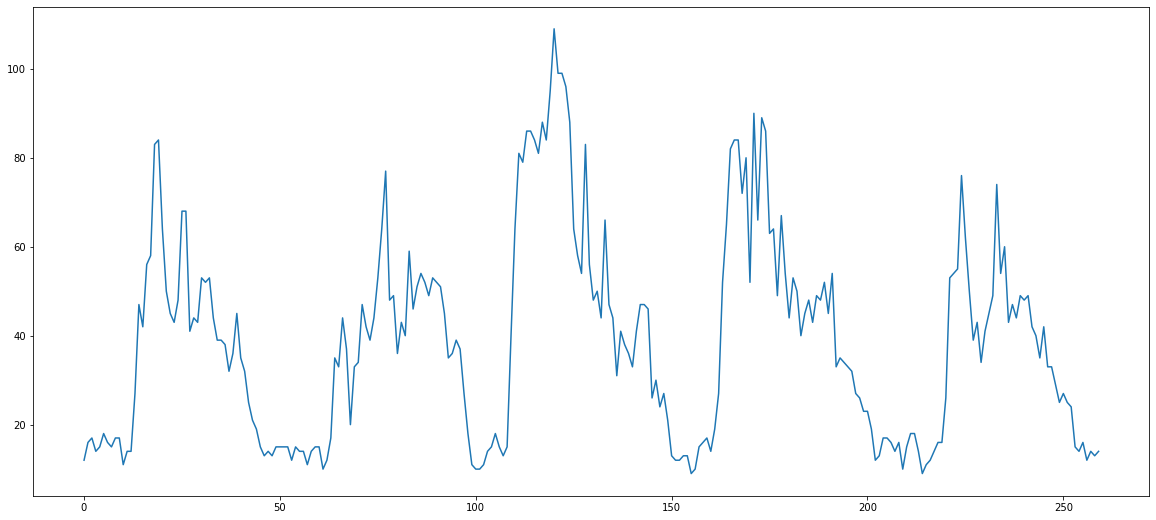

In [33]:
plt.plot(sj_predictions)

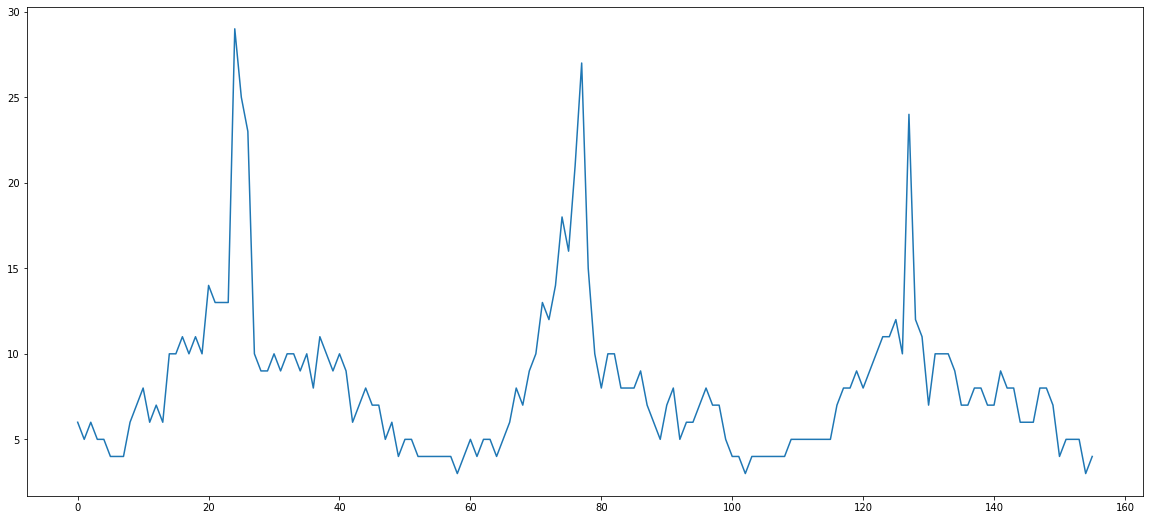

In [34]:
plt.plot(iq_predictions)